In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [30]:
import pickle
import glob
from tqdm.notebook import trange, tqdm
import json
import re
import pandas as pd
import numpy as np
from features import prepare_entry
from utills import colnum_string, compress_fraction
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

In [4]:
BASE_PATH = '../data/reddit/'
COMPUTED_DATA_PATH = '../temp_data/reddit/preprocessed/'

Randomly Split Train/Test sets
==

In [6]:
files = glob.glob(BASE_PATH + '*.jsonl')
np.random.shuffle(files)
train_files = files[:int(len(files) * 0.7)]
test_files = files[int(len(files) * 0.7):]
print(len(train_files), len(test_files))
min_count = 20

50644 21705


In [7]:
with open(COMPUTED_DATA_PATH + 'metadata_all.p', 'wb') as f:
    pickle.dump((train_files, test_files, min_count), f)

Preprocess Data
===
This is done on the HPC. Call `reddit_preprocess_hpc.py` and copy over the results

In [ ]:
with open(COMPUTED_DATA_PATH + 'train_all.jsonl', 'w') as fout:
    for i in trange(10):
        with open(COMPUTED_DATA_PATH + 'train' + str(i) + '.jsonl', 'r') as f:
            for l in f:
                _ = fout.write(l)
                
author_mapping = {}
for i in trange(10):
    with open(COMPUTED_DATA_PATH + 'author_mapping_' + str(i) + '.p', 'rb') as f:
        am = pickle.load(f)
        for k, v in am.items():
            author_mapping[k] = v
            
with open(COMPUTED_DATA_PATH + 'test_all.jsonl', 'w') as fout:
    for i in trange(10):
        with open(COMPUTED_DATA_PATH + 'test' + str(i) + '.jsonl', 'r') as f:
            for l in f:
                _ = fout.write(l)
                
for i in trange(10):
    with open(COMPUTED_DATA_PATH + 'author_mapping_test_' + str(i) + '.p', 'rb') as f:
        am = pickle.load(f)
        for k, v in am.items():
            author_mapping[k] = v

In [13]:
with open(COMPUTED_DATA_PATH + 'metadata_all.p', 'wb') as f:
    pickle.dump((train_files, test_files, min_count, author_mapping), f)

Filter Repititive Users
====

In [5]:
with open(COMPUTED_DATA_PATH + 'metadata_all.p', 'rb') as f:
    (train_files, test_files, min_count, author_mapping) = pickle.load(f)

In [8]:
user_compress_fraction = {}
with open(COMPUTED_DATA_PATH + 'train_all.jsonl', 'r') as f:
    for l in tqdm(f, total=len(train_files)):
        d = json.loads(l)
        user_compress_fraction[d['username']] = compress_fraction('\n'.join([c['preprocessed'] for c in d['data']]))

with open(COMPUTED_DATA_PATH + 'test_all.jsonl', 'r') as f:
    for l in tqdm(f, total=len(test_files)):
        d = json.loads(l)
        user_compress_fraction[d['username']] = compress_fraction('\n'.join([c['preprocessed'] for c in d['data']]))        

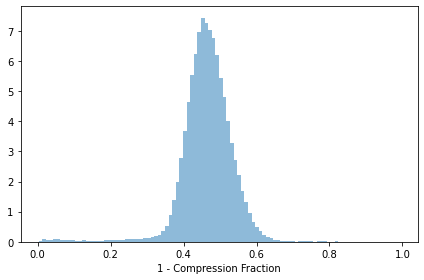

In [11]:
fig, ax = plt.subplots()

ax.hist(list(user_compress_fraction.values()), bins=100, alpha=0.5, density=True)

ax.set_xlabel('1 - Compression Fraction')

plt.tight_layout()
plt.show()

In [28]:
repititive_users_roots = set([re.search(r'(.*)_[A-Z]+$', u).group(1) for u, f in user_compress_fraction.items() if f < 0.25])

In [38]:
filtered_author_mapping = defaultdict(set)
with open(COMPUTED_DATA_PATH + 'train_all.jsonl', 'r') as f, open(COMPUTED_DATA_PATH + 'train.jsonl', 'w') as fout:
    for l in f:
        d = json.loads(l)
        u_root = re.search(r'(.*)_[A-Z]+$', d['username']).group(1)
        if u_root not in repititive_users_roots:
            filtered_author_mapping[u_root].add(d['username'])
            _ = fout.write(l)

In [40]:
with open(COMPUTED_DATA_PATH + 'test_all.jsonl', 'r') as f, open(COMPUTED_DATA_PATH + 'test.jsonl', 'w') as fout:
    for l in f:
        d = json.loads(l)
        u_root = re.search(r'(.*)_[A-Z]+$', d['username']).group(1)
        if u_root not in repititive_users_roots:
            filtered_author_mapping[u_root].add(d['username'])
            _ = fout.write(l)

In [51]:
filtered_train_files = [f for f in train_files if f.replace('../data/reddit_2/', '/scratch/jnw301/av/data/reddit_2/reddit_2/').replace('.jsonl', '') in filtered_author_mapping]
filtered_test_files = [f for f in test_files if f.replace('../data/reddit_2/', '/scratch/jnw301/av/data/reddit_2/reddit_2/').replace('.jsonl', '') in filtered_author_mapping]

In [52]:
with open(COMPUTED_DATA_PATH + 'metadata.p', 'wb') as f:
    pickle.dump((filtered_train_files, filtered_test_files, min_count, filtered_author_mapping), f)